# MAM02 - Week 2
*Authors*: Robin & Matias

*Status*: Draft

*Date*: 8.10.2024

## Introduction

In this analysis, we aim to investigate the association between 20 risk factors and the occurrence of cardiovascular disease (CVD) events in patients with familial hypercholesterolemia (FH).

In [9]:
import pandas as pd

# Load the given data file
data = pd.read_spss("GIRAFH.SAV")

# Some general data descriptions
print(data.head())
print(data.info())
print(data.describe())

      sex  height  weight        bmi alcoholuse smoking  systbp  diasbp  \
0  female   174.0    77.0  25.432686         no    Ever   140.0    95.0   
1    male   179.0    65.0  20.286508        yes    Ever   140.0    95.0   
2    male   183.0    85.0  25.381469        yes    Ever   130.0    85.0   
3  female   169.0    63.0  22.058051        yes    Ever   130.0    75.0   
4    male   176.0    88.0  28.409091        yes   Never   120.0    80.0   

  hypertension  Glucose  ...  diabetes familiarHC     Tc   HDL    Tg    Lpa  \
0          yes      4.7  ...      ever        yes  11.22  1.00  1.40    NaN   
1           no      4.5  ...      ever         no  11.50  1.04  0.81  740.0   
2           no      4.7  ...      ever         no  11.36  1.64  1.67    NaN   
3           no      4.6  ...      ever         no  10.21  1.07  1.18    NaN   
4           no      5.4  ...      ever         no  10.09  1.69  1.01    NaN   

   homocysteine  creatinine        age  event  
0          12.1        75.

In [10]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

sex                0
height           320
weight           205
bmi              342
alcoholuse       491
smoking          234
systbp            37
diasbp            37
hypertension      24
Glucose          118
Hba1c            930
diabetes           0
familiarHC         0
Tc               248
HDL              440
Tg               374
Lpa              702
homocysteine    1306
creatinine        71
age                0
event              0
dtype: int64


## Handling Missing Data

*Discarding Missing Values* can lead to losing essential information, especially if missingness is not completely random.
*Multiple Imputation* preserves the dataset's size by filling in the missing values based on other available data

*Chosen Method*: Multiple Imputation

*Rationale*: Given the size of the dataset (2,400 patients) and the potential loss of information, we choose multiple imputation to handle missing values. We believe this method allows us to use all available data better and reduce the bias that might result from simply discarding missing values.

In [11]:
from sklearn.impute import SimpleImputer

imputer_mean = SimpleImputer(strategy='mean')
imputer_freq = SimpleImputer(strategy='most_frequent')

continuous_vars = ['height', 'weight', 'bmi', 'systbp', 'diasbp', 'Glucose', 'Hba1c', 'Tc', 'HDL', 'Tg', 'Lpa', 'homocysteine', 'creatinine', 'age']
categorical_vars = ['sex', 'alcoholuse', 'smoking', 'hypertension', 'diabetes', 'familiarHC', 'event']

data[continuous_vars] = imputer_mean.fit_transform(data[continuous_vars])

data[categorical_vars] = imputer_freq.fit_transform(data[categorical_vars])

In [12]:
missing_values = data.isnull().sum()
print(missing_values)

sex             0
height          0
weight          0
bmi             0
alcoholuse      0
smoking         0
systbp          0
diasbp          0
hypertension    0
Glucose         0
Hba1c           0
diabetes        0
familiarHC      0
Tc              0
HDL             0
Tg              0
Lpa             0
homocysteine    0
creatinine      0
age             0
event           0
dtype: int64


## Descriptive Statistics

Compare the means of continuous variables between the event and no-event groups using t-tests to identify significant differences.

In [13]:
from scipy.stats import ttest_ind


event_data = data[data['event'] == 'yes']
no_event_data = data[data['event'] == 'none']

def create_summary_table(var_list):
    # Initialize an empty list to store rows
    rows = []
    for var in var_list:
        event_mean = event_data[var].mean()
        no_event_mean = no_event_data[var].mean()
        #  t-test
        t_stat, p_val = ttest_ind(event_data[var], no_event_data[var], nan_policy='omit')

        row = {'Variable': var,
               'Event Mean': event_mean,
               'No Event Mean': no_event_mean,
               'P-Value': p_val}

        rows.append(row)

    summary_table = pd.DataFrame(rows)
    return summary_table

summary_continuous = create_summary_table(continuous_vars)
print(summary_continuous)



        Variable  Event Mean  No Event Mean       P-Value
0         height  172.340862     172.528421  6.191569e-01
1         weight   76.434827      74.207192  6.203391e-05
2            bmi   25.631893      24.859753  7.984809e-08
3         systbp  138.245550     133.436406  9.645333e-09
4         diasbp   83.395754      81.196731  1.241415e-06
5        Glucose    5.321026       4.962398  7.917314e-17
6          Hba1c    5.972410       5.698620  6.852495e-11
7             Tc    9.668917       9.469821  1.589363e-02
8            HDL    1.160368       1.234116  1.141435e-07
9             Tg    2.005692       1.707883  3.584563e-13
10           Lpa  407.589526     304.242450  1.226179e-11
11  homocysteine   13.153659      12.103829  5.508880e-05
12    creatinine   84.471159      79.725495  8.022937e-13
13           age   48.419700      46.413791  1.541438e-04


For categorical variables, we use chi-squared tests to compare the proportions between the two groups.

In [14]:
from scipy.stats import chi2_contingency


def create_categorical_summary(var_list):
    rows = []
    for var in var_list:
        event_counts = event_data[var].value_counts(normalize=True)
        no_event_counts = no_event_data[var].value_counts(normalize=True)

        # use the chi for the categorical only
        contingency_table = pd.crosstab(data[var], data['event'])
        chi2, p_val, dof, ex = chi2_contingency(contingency_table)

        row = {'Variable': var,
               'Event Proportion': event_counts.to_dict(),
               'No Event Proportion': no_event_counts.to_dict(),
               'P-Value': p_val}
        rows.append(row)

    summary_table = pd.DataFrame(rows)
    return summary_table


summary_categorical = create_categorical_summary(categorical_vars)


print(summary_categorical)


       Variable                                   Event Proportion  \
0           sex  {'male': 0.6227621483375959, 'female': 0.37723...   
1    alcoholuse  {'yes': 0.7864450127877238, 'no': 0.2135549872...   
2       smoking  {'Ever': 0.8414322250639387, 'Never': 0.158567...   
3  hypertension  {'no': 0.8286445012787724, 'yes': 0.1713554987...   
4      diabetes  {'ever': 0.8887468030690537, 'never': 0.111253...   
5    familiarHC  {'no': 0.840153452685422, 'yes': 0.15984654731...   
6         event                                       {'yes': 1.0}   

                                 No Event Proportion       P-Value  
0  {'female': 0.5716934487021014, 'male': 0.42830...  6.255881e-19  
1  {'yes': 0.7966625463535228, 'no': 0.2033374536...  5.991600e-01  
2  {'Ever': 0.7255871446229913, 'Never': 0.274412...  5.406920e-10  
3  {'no': 0.9406674907292955, 'yes': 0.0593325092...  4.554371e-18  
4  {'ever': 0.9684796044499382, 'never': 0.031520...  7.813679e-15  
5  {'no': 0.7663782447466

## Univariate Logistic Regression Analyses

#### Performing Univariate Analyses

We first need to preprocess the categorical variables so that they're ready for further computation, we need to avoid the current string format of the values. This means the next step for each categorical variable is to transform the string values to numeric ones, that correspond to a unique integer ID representative of each distinct category. This process is called label encoding

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data_encoded = data.copy()
for category in categorical_vars:
    data_encoded[category] = le.fit_transform(data_encoded[category])

print(data_encoded.info())
print(data_encoded.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sex           2400 non-null   int64  
 1   height        2400 non-null   float64
 2   weight        2400 non-null   float64
 3   bmi           2400 non-null   float64
 4   alcoholuse    2400 non-null   int64  
 5   smoking       2400 non-null   int64  
 6   systbp        2400 non-null   float64
 7   diasbp        2400 non-null   float64
 8   hypertension  2400 non-null   int64  
 9   Glucose       2400 non-null   float64
 10  Hba1c         2400 non-null   float64
 11  diabetes      2400 non-null   int64  
 12  familiarHC    2400 non-null   int64  
 13  Tc            2400 non-null   float64
 14  HDL           2400 non-null   float64
 15  Tg            2400 non-null   float64
 16  Lpa           2400 non-null   float64
 17  homocysteine  2400 non-null   float64
 18  creatinine    2400 non-null 

### We chose logistic regression

Rationale: Linear regression is for regression. Logistic regression for classification. Logistic regression is called a regression nonetheless, since in principle it is very close to the concept of linear regression. The difference is that the linear combination of the feature vector and the coefficient vector βᵀx is then passed through the sigmoid function in order to transform the range of returned values from (-∞, +∞) to [0, 1]. This particularly useful trait makes logistic regression perfect for binary classification tasks which is the case in this one (event: yes/no)


Next, we are going to loop through each predictor variable, build the model, and calculate some results.

In [17]:
import numpy as np
import statsmodels.api as sm
import pandas as pd

univariate_results_list = []


for var in continuous_vars + categorical_vars:
    if var != 'event':
        model = sm.Logit(data_encoded['event'], sm.add_constant(data_encoded[var]))
        result = model.fit(disp=0)
        
        odds_ratio = np.exp(result.params.iloc[1])
        p_value = result.pvalues.iloc[1]
        conf = result.conf_int()
        lower_ci = np.exp(conf.iloc[1, 0])
        upper_ci = np.exp(conf.iloc[1, 1])
        
        univariate_results_list.append({'Variable': var,
                                        'Odds Ratio': odds_ratio,
                                        'P-Value': p_value,
                                        '95% CI Lower': lower_ci,
                                        '95% CI Upper': upper_ci})

univariate_results = pd.DataFrame(univariate_results_list)
print(univariate_results)


        Variable  Odds Ratio       P-Value  95% CI Lower  95% CI Upper
0         height    0.997501  6.190016e-01      0.987711      1.007387
1         weight    1.013556  7.010999e-05      1.006851      1.020306
2            bmi    1.072825  1.191089e-07      1.045270      1.101108
3         systbp    1.012798  1.473752e-08      1.008352      1.017264
4         diasbp    1.020437  1.523080e-06      1.012056      1.028887
5        Glucose    1.477631  4.298073e-14      1.335232      1.635217
6          Hba1c    1.335813  8.573775e-10      1.217773      1.465294
7             Tc    1.056188  1.608361e-02      1.010205      1.104265
8            HDL    0.460673  1.536473e-07      0.344893      0.615321
9             Tg    1.382158  3.981479e-12      1.261391      1.514488
10           Lpa    1.000799  1.109277e-10      1.000556      1.001042
11  homocysteine    1.044978  1.721842e-04      1.021265      1.069241
12    creatinine    1.020444  3.255071e-12      1.014650      1.026271
13    

## Multivariable Logistic Regression Model


We first include all predictor variables in the multivariable logistic regression model to assess their combined effect on the outcome.

In [18]:
predictors = data_encoded.drop(columns=['event'])

predictors = sm.add_constant(predictors)

# Build the logistic regression model
model = sm.Logit(data_encoded['event'], predictors)
multivar_result = model.fit()


Optimization terminated successfully.
         Current function value: 0.551286
         Iterations 6


#### Checking for Multicollinearity

Multicollinearity among predictors can inflate the variance of coefficient estimates and make the model unstable. We calculate the VIF to detect multicollinearity. Variables with VIF > 5 may need to be removed or combined.

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = predictors.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(predictors.values, i)
                   for i in range(len(predictors.columns))]

print(vif_data)


         feature          VIF
0          const  2370.531062
1            sex     2.194665
2         height     5.512755
3         weight    12.308550
4            bmi     7.879261
5     alcoholuse     1.057499
6        smoking     1.041734
7         systbp     2.008979
8         diasbp     1.903956
9   hypertension     1.154098
10       Glucose     1.541073
11         Hba1c     1.167913
12      diabetes     1.515626
13    familiarHC     1.023789
14            Tc     1.053018
15           HDL     1.226671
16            Tg     1.277541
17           Lpa     1.012756
18  homocysteine     1.015721
19    creatinine     1.465287
20           age     1.335832


## Considering Transformations and Interactions

#### Determining Skewed Variables and Applying Transformations

Skewness refers to the asymmetry in the distribution of a variable. A skewed distribution can impact the performance of regression models, as many statistical techniques assume the normality of the predictors. Transforming skewed variables can help improve model performance.

#### Assessing Skewness

We'll start by doing a visual inspection and then go on to use existing tools to quantify skewness

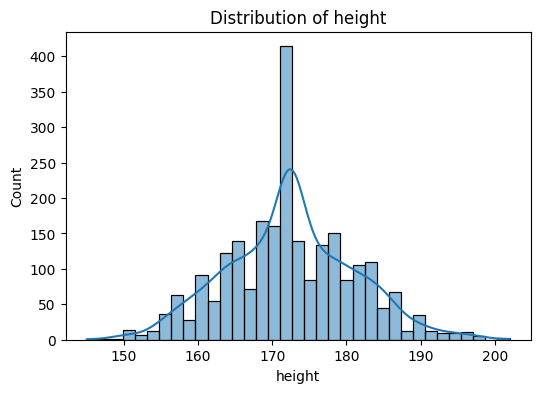

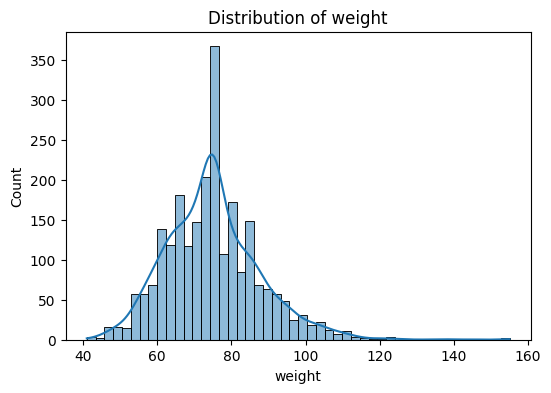

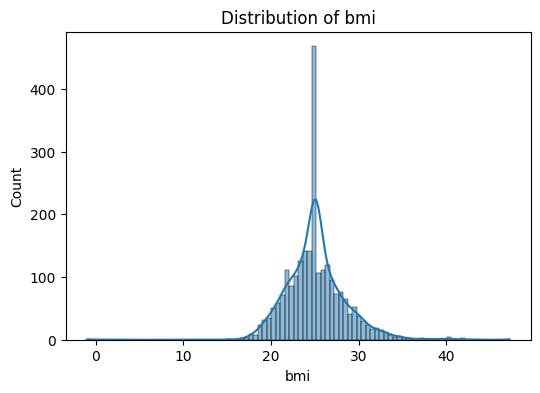

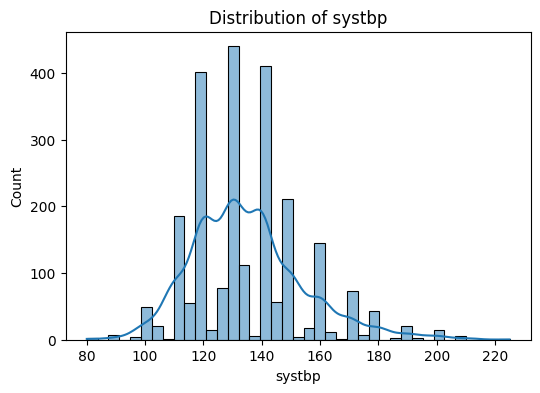

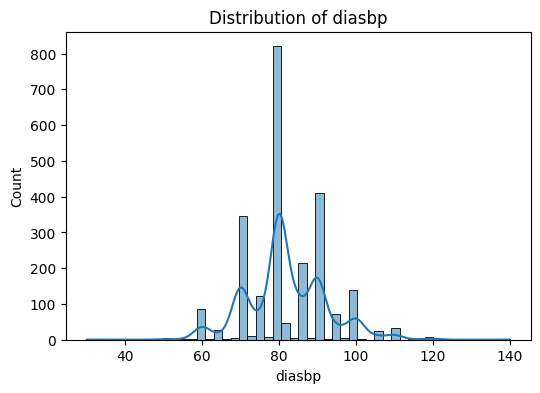

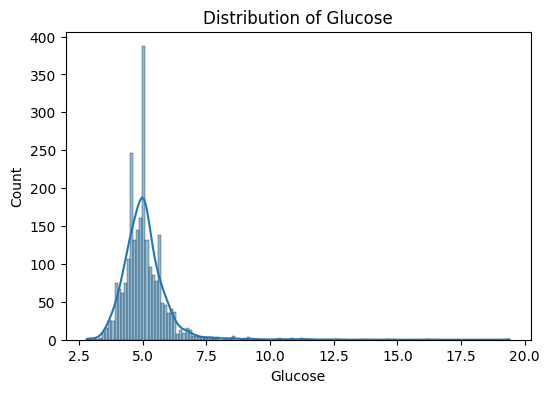

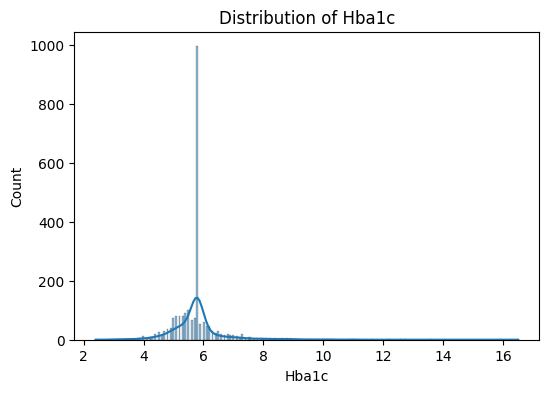

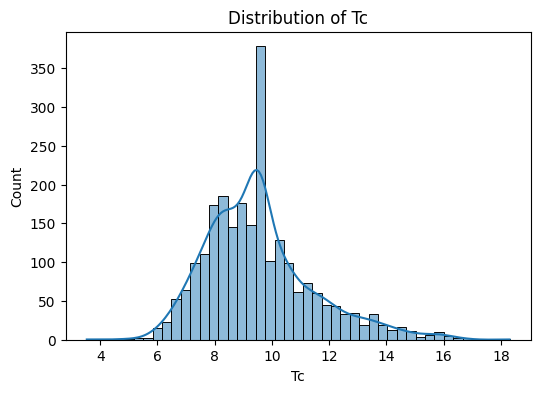

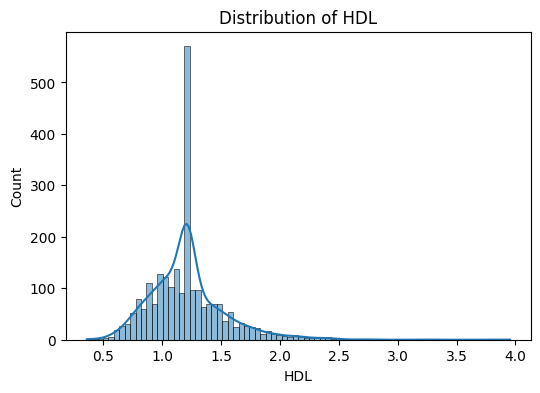

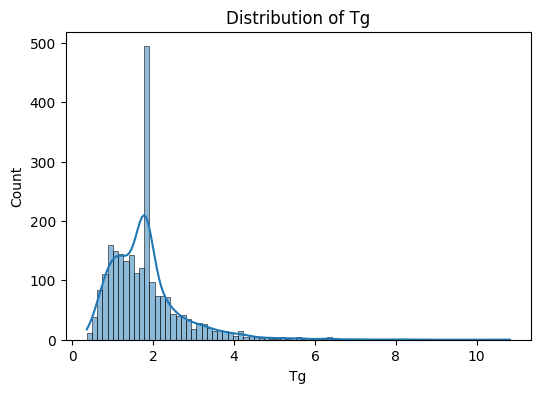

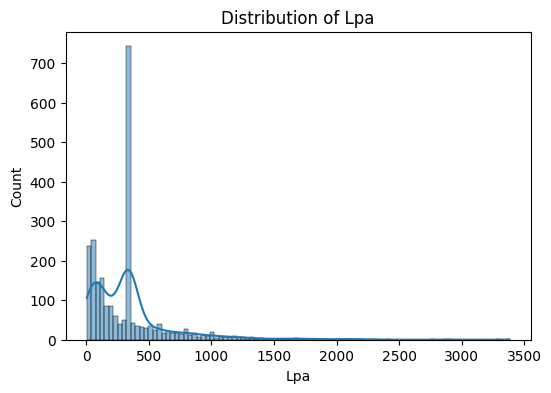

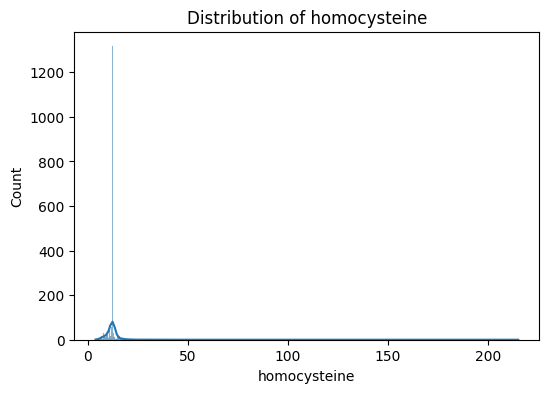

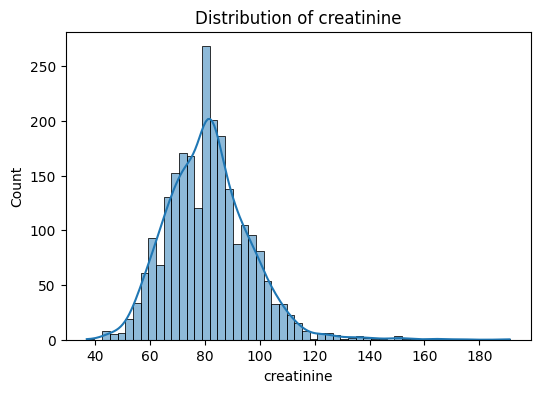

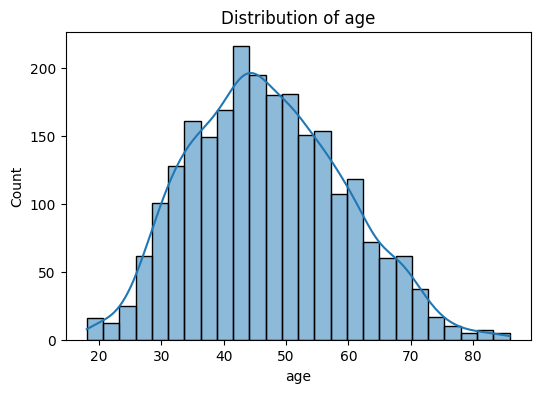

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns


for var in continuous_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.show()


In [29]:
# Calculate skewness for continuous variables.
from scipy.stats import skew

skewness_coefficients = {}
for var in continuous_vars:
    skewness = skew(data_encoded[var].dropna())
    skewness_coefficients[var] = skewness
    print(f'Skewness of {var}: {skewness:.2f}')


Skewness of height: 0.11
Skewness of weight: 0.78
Skewness of bmi: 0.62
Skewness of systbp: 0.78
Skewness of diasbp: 0.31
Skewness of Glucose: 4.25
Skewness of Hba1c: 3.04
Skewness of Tc: 0.91
Skewness of HDL: 1.25
Skewness of Tg: 2.30
Skewness of Lpa: 2.87
Skewness of homocysteine: 19.48
Skewness of creatinine: 0.90
Skewness of age: 0.27


##### Interpretation
- Skewness ≈ 0: The distribution is approximately symmetric.
- Skewness > 0: The distribution is positively skewed (tail to the right).
- Skewness < 0: The distribution is negatively skewed (tail to the left).
- Thresholds: A skewness coefficient greater than ±1 indicates a highly skewed distribution.

From the result we can determine that Glucose, Hba1c, HDL, Tg, Lpa, and Homocysteine can be considered skewed. Next, we'll apply log transformation which reduces "right skewness" by compressing large values and stretching small values. If the variable contains zero or negative values, we shift the data to make all values positive before applying the log transformation (we don't have any in our data set but for sake of completeness we'll implement it in code).

In [48]:
skewed_vars = ['Glucose', 'Hba1c', 'HDL', 'Tg', 'Lpa', 'homocysteine']

for var in skewed_vars:
    # Check for non-positive values
    if (data_encoded[var] <= 0).any():
        # If yes -> shift
        min_value = data_encoded[var].min()
        data_encoded[var + '_log'] = np.log(data_encoded[var] - min_value + 1)
    else:
        data_encoded[var + '_log'] = np.log(data_encoded[var] + 1)


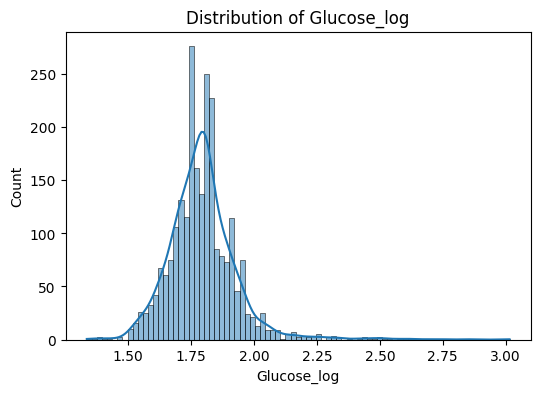

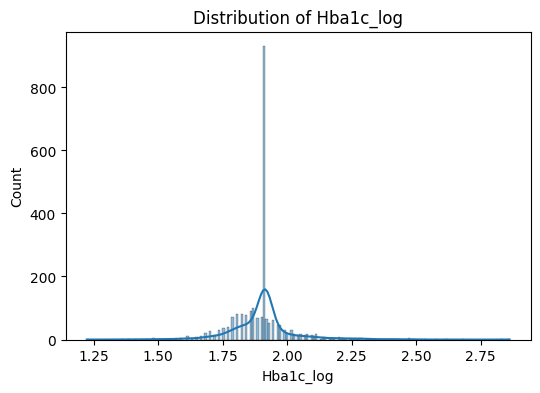

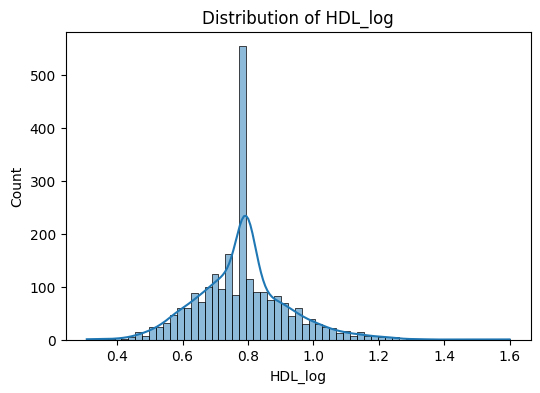

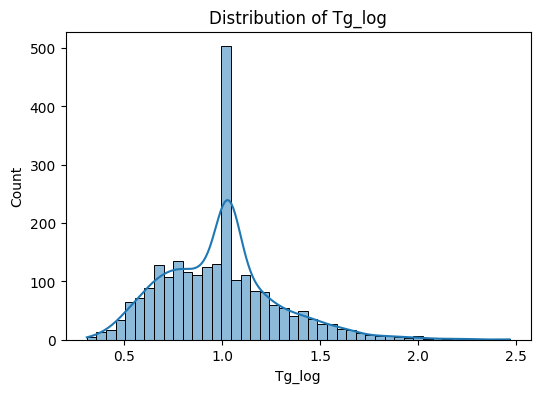

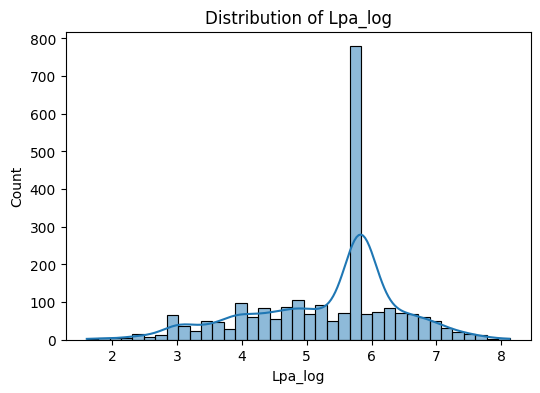

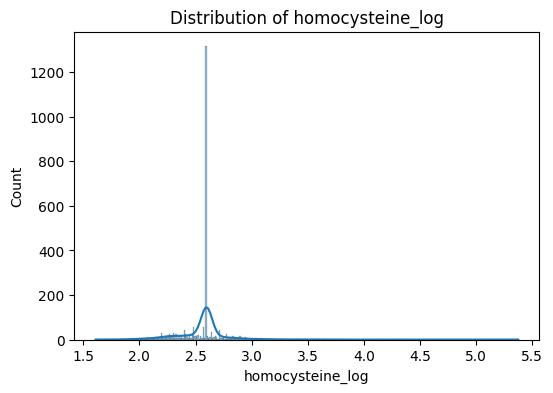

In [49]:
for var in skewed_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[var + '_log'], kde=True)
    plt.title(f'Distribution of {var}_log')
    plt.show()


In [50]:
# Update continuous variables
continuous_vars_transformed = [var + '_log' if var in skewed_vars else var for var in continuous_vars]
print(continuous_vars_transformed)


['height', 'weight', 'bmi', 'systbp', 'diasbp', 'Glucose_log', 'Hba1c_log', 'Tc', 'HDL_log', 'Tg_log', 'Lpa_log', 'homocysteine_log', 'creatinine', 'age']


#### Identifying Potential Interactions Between Variables

An interaction occurs when the effect of one predictor variable on the outcome depends on the level of another predictor variable. Including interaction terms in the model can improve predictive accuracy if such relationships exist.

Way to identify interactions:
- Domain Knowledge (For example, the effect of systolic blood pressure on CVD risk may differ between males and females.)
- Exploratory Data Analysis (EDA) E.g. Plot the relationship between predictors and the outcome, stratified by another variable.) Example: Plotting CVD event rates against blood pressure for males and females separately.
- Statistical Tests. Include interaction terms (Multiply two predictor variables together.) in the model and test their significance.

In [61]:
# TODO ???
# Should we do this?

# interaction terms
data_encoded['sex_systbp_interaction'] = data_encoded['sex'] * data_encoded['systbp']

interaction_predictors = ['sex_systbp_interaction'] + continuous_vars_transformed + categorical_vars

x = data_encoded[interaction_predictors].drop(columns=['event'])
y = data_encoded['event']

x = sm.add_constant(x)

interaction_model = sm.Logit(y, x)
interaction_result = interaction_model.fit()

print(interaction_result.summary())



Optimization terminated successfully.
         Current function value: 0.550716
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  event   No. Observations:                 2400
Model:                          Logit   Df Residuals:                     2378
Method:                           MLE   Df Model:                           21
Date:                Wed, 09 Oct 2024   Pseudo R-squ.:                  0.1275
Time:                        12:36:12   Log-Likelihood:                -1321.7
converged:                       True   LL-Null:                       -1514.9
Covariance Type:            nonrobust   LLR p-value:                 6.404e-69
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -5.5359      2.644     -2.093      0.036     -10.719      

P-value indicates that the effect of systolic blood pressure on the risk of a CVD event DOES NOT differ between males and females.


Let's try a few more just for fun.


In [62]:
data_encoded['age_diabetes_interaction'] = data_encoded['age'] * data_encoded['diabetes']
data_encoded['smoking_hdl_interaction'] = data_encoded['smoking'] * data_encoded['HDL_log']

interaction_predictors = interaction_predictors + ['age_diabetes_interaction', 'smoking_hdl_interaction']

x = data_encoded[interaction_predictors].drop(columns=['event'])
y = data_encoded['event']

x = sm.add_constant(x)

interaction_model = sm.Logit(y, x)
interaction_result = interaction_model.fit()

print(interaction_result.summary())


Optimization terminated successfully.
         Current function value: 0.549159
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  event   No. Observations:                 2400
Model:                          Logit   Df Residuals:                     2376
Method:                           MLE   Df Model:                           23
Date:                Wed, 09 Oct 2024   Pseudo R-squ.:                  0.1300
Time:                        12:36:14   Log-Likelihood:                -1318.0
converged:                       True   LL-Null:                       -1514.9
Covariance Type:            nonrobust   LLR p-value:                 3.448e-69
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -5.5957      2.654     -2.109      0.035     -10.797

No significance, we shall move on.


#### Rebuilding the Model with Transformations (and Interactions if we had any)


In [75]:
# Rebuild the logistic regression model
predictors = continuous_vars_transformed + categorical_vars

x = data_encoded[predictors].drop(columns=['event'])
y = data_encoded['event']

x = sm.add_constant(x)

model_transformed = sm.Logit(y, x)
result_transformed = model_transformed.fit()

print(result_transformed.summary())

Optimization terminated successfully.
         Current function value: 0.550733
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  event   No. Observations:                 2400
Model:                          Logit   Df Residuals:                     2379
Method:                           MLE   Df Model:                           20
Date:                Wed, 09 Oct 2024   Pseudo R-squ.:                  0.1275
Time:                        12:46:01   Log-Likelihood:                -1321.8
converged:                       True   LL-Null:                       -1514.9
Covariance Type:            nonrobust   LLR p-value:                 1.491e-69
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.4848      2.639     -2.078      0.038     -10.657      -0.313
height     

## Evaluating Model Performance

Optimization terminated successfully.
         Current function value: 0.561436
         Iterations 6
[[455  40]
 [140  85]]
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       495
           1       0.68      0.38      0.49       225

    accuracy                           0.75       720
   macro avg       0.72      0.65      0.66       720
weighted avg       0.74      0.75      0.73       720



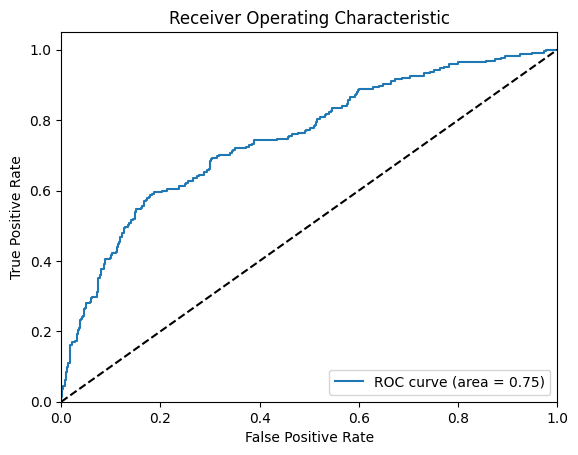

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

x = data_encoded[predictors].drop(columns=['event'])

X_train, X_test, y_train, y_test = train_test_split(x, data_encoded['event'], test_size=0.3, random_state=42)

model_final = sm.Logit(y_train, X_train)
result_final = model_final.fit()

# predict probabilities
y_pred_prob = result_final.predict(X_test)

# predict classes
y_pred_class = [1 if x > 0.5 else 0 for x in y_pred_prob]

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)
print(conf_matrix)

# classification report
class_report = classification_report(y_test, y_pred_class)
print(class_report)

# roc and auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



##### TODO: Some analysis

## Variable Selection
#### Applying LASSO Regression
LASSO regression performs variable selection by penalizing the absolute size of the coefficients.

In [88]:
from sklearn.linear_model import LogisticRegressionCV

# LASSO (L1) regularization for variable selection
lasso_model = LogisticRegressionCV(cv=5, penalty='l1', solver='saga',scoring='roc_auc', max_iter=10000)
lasso_model.fit(X_train, y_train)

coef = pd.Series(lasso_model.coef_[0], index=X_train.columns)

# Selected variables (aka non-zero coefficients)
selected_vars = coef[coef != 0].index.tolist()
print("Selected variables:", selected_vars)
print("Difference to predictions:", [x for x in selected_vars if x not in predictors])


Selected variables: ['height', 'weight', 'bmi', 'systbp', 'diasbp', 'Glucose_log', 'Hba1c_log', 'Tc', 'HDL_log', 'Tg_log', 'Lpa_log', 'homocysteine_log', 'creatinine', 'age', 'sex', 'alcoholuse', 'smoking', 'hypertension', 'diabetes', 'familiarHC']
Difference to predictions: []


Same columns, we could try a different methods such as backward elimination based on p-values or forward selection

## Final Model

Optimization terminated successfully.
         Current function value: 0.561436
         Iterations 6


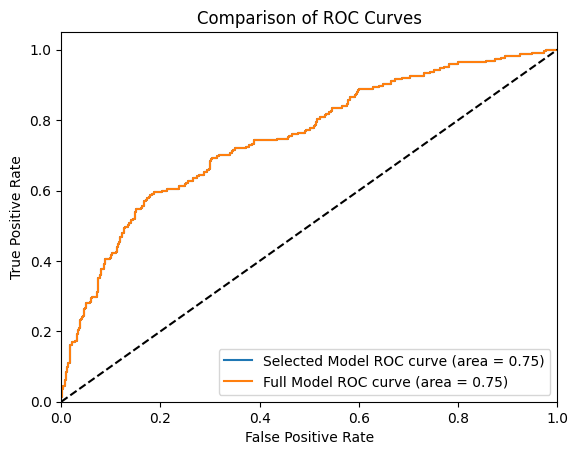

In [86]:
X_train_selected = X_train[selected_vars]
X_test_selected = X_test[selected_vars]

model_selected = sm.Logit(y_train, X_train_selected)
result_selected = model_selected.fit()

y_pred_prob_selected = result_selected.predict(X_test_selected)
y_pred_class_selected = [1 if x > 0.5 else 0 for x in y_pred_prob_selected]

fpr_sel, tpr_sel, thresholds_sel = roc_curve(y_test, y_pred_prob_selected)
roc_auc_sel = auc(fpr_sel, tpr_sel)

plt.figure()
plt.plot(fpr_sel, tpr_sel, label='Selected Model ROC curve (area = %0.2f)' % roc_auc_sel)
plt.plot(fpr, tpr, label='Full Model ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves')
plt.legend(loc="lower right")
plt.show()


In [ ]:
The same but that is just because our selection method included all variables.